In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage
import os


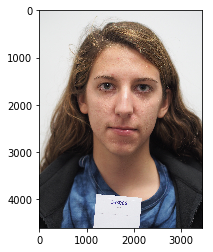

In [14]:
img = cv2.imread('voice_to_face_data/2d_photos/FEMMES/F163066.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

#img = np.transpose(img,(1,0,2))
#img = np.flip(img, axis=0)
img.shape

plt.imshow(img)

In [10]:
def get_rid_of_background(img):
    img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    MASK_COLOR = (1.0,1.0,1.0) # In BGR format
    edges = cv2.Canny(img_g, 10, 30)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    
    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    _, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Previously, for a previous version of cv2, this line was: 
    #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Thanks to notes from commenters, I've updated the code but left this note
    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))
    
    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=10)
    mask = cv2.erode(mask, None, iterations=10)
    mask = cv2.GaussianBlur(mask, (21, 21), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 
    
    return masked


In [11]:
def crop(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    temp = img
    aa = np.array([[1,2,3],[4,5,6],[7,8,9]])
    np.linalg.norm(aa, axis=1)
    np.average(aa, axis=0)
    #columns
    #crop out columns that are all background
    cols = np.average(gray, axis=0)
    left = 0
    for i, c in enumerate(cols):
        if (c != 255):
            left = i
            break
    gray = gray[:,left:]
    temp = temp[:,left:]
        
    cols = np.average(gray, axis=0)
    right = len(cols)
    for i, c in enumerate(cols):
        if (c == 255):
            right = i-1
            break

    gray = gray[:,:right]
    temp = temp[:,:right]

    # Now do rows
    rows = np.average(gray, axis=1)
    top = 0
    for i, r in enumerate(rows):
        if (r != 255):
            top = i
            break

    gray = gray[top:,:]
    temp = temp[top:,:]
        
    rows = np.average(gray, axis=1)     
    bottom = len(rows)
    for i, r in enumerate(rows):
        if (r == 255):
            bottom = i-1
            break
    gray = gray[:bottom,:]
    temp = temp[:bottom,:]
    return temp


In [12]:
def grayscale(rgb): 
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def dodge(front,back): 
    result=front*255/(255-back)  
    result[result>255]=255 
    result[back==255]=255 
    return result.astype("uint8")

def sketch(img):
    gray_img = grayscale(img)
    inverted_img = 255-gray_img
    blur_img = scipy.ndimage.filters.gaussian_filter(inverted_img,sigma=75)
    final_img= dodge(blur_img,gray_img)
    return final_img
    

In [5]:
def recog(img):
    cascPath = "haarcascade_frontalface_default.xml"

    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    # Read the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))#, flags = cv2.CV_HAAR_SCALE_IMAGE)
    print("Found {0} faces!".format(len(faces)))
    #print(faces)
    # Draw a rectangle around the faces
    face = np.zeros(4, dtype=int)
    if(len(faces) > 1):
        for (x, y, w, h) in faces:
            if (w>face[2]):
                face[0] = x
                face[1] = y
                face[2] = w
                face[3] = h
        #print("shimed down\n")
    if(len(faces) == 1):
        face = faces[0]
        #print("1 face, you good\n")
    if(len(faces) == 0):
        print("NO FACES!!!!!\n")
        return img
    
    print(face)
    img = img[face[1]:face[1]+face[3],face[0]:face[0]+face[2]]
    return img

Found 2 faces!
[ 693  788 2184 2184]


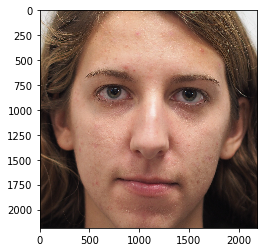

In [15]:
#res = get_rid_of_background(img)
#res = crop(res)
#res = sketch(res)
res = recog(img)
plt.imshow(res, cmap='gray')  
#res2 = get_rid_of_background(res)
 

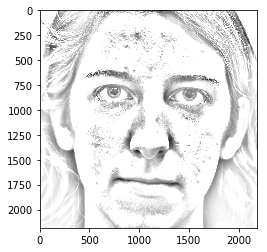

In [16]:
#res[:100,:100] = 0
#plt.imshow(res, cmap='gray')  
res2 = sketch(res)
plt.imshow(res2, cmap='gray') 

In [9]:
#np.min(res)


In [10]:
# Get list of image file names
filenames = os.listdir(path='voice_to_face_data/2d_photos/FEMMES_remaining/')
for i, name in enumerate(filenames):
    img = cv2.imread('voice_to_face_data/2d_photos/FEMMES_remaining/'+name, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = recog(img)
    #cv2.imwrite('voice_to_face_data/2d_photos/FEMMESrecog/'+name,res)

    #res = get_rid_of_background(img)
    #cv2.imwrite('voice_to_face_data/2d_photos/FEMMESback/'+name,res)

    #res = crop(res)
    #cv2.imwrite('voice_to_face_data/2d_photos/FEMMEScrop/'+name,res)

    res = sketch(res)
    cv2.imwrite('voice_to_face_data/2d_photos/FEMMESsketch/'+name,res)
    print((i+1), ' / ', len(filenames))

In [117]:
# Get list of image file names
filenames = os.listdir(path='voice_to_face_data/2d_photos/ADAPT_remaining/')
#filenames[0] = '143752.JPG'
print(filenames)
for i, name in enumerate(filenames):
    img = cv2.imread('voice_to_face_data/2d_photos/ADAPT/'+name, cv2.IMREAD_UNCHANGED)
    #print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = np.transpose(img,(1,0,2))
    #img = np.flip(img, axis=0)
    res = recog(img)
    #cv2.imwrite('voice_to_face_data/2d_photos/ADAPTrecog/'+name,res)
    #res = get_rid_of_background(img)
    #cv2.imwrite('voice_to_face_data/2d_photos/ADAPTback/'+name,res)

    #res = crop(res)
    #cv2.imwrite('voice_to_face_data/2d_photos/ADAPTcrop/'+name,res)

    res = sketch(img)
    cv2.imwrite('voice_to_face_data/2d_photos/ADAPTsketch/'+name,res)
    print((i+1), ' / ', len(filenames))

['140382.JPG', '140429.JPG', '143761.JPG', '143761_copy.jpg']
Found 3 faces!
[ 79 116 216 216]
1  /  4
Found 4 faces!
[153 154 176 176]
2  /  4
Found 172 faces!
[316 994 543 543]
3  /  4
Found 7 faces!
[ 223  340 1255 1255]
4  /  4
